# Stretching epitopes
`epimap` provides several functions to help analyse epitopes along a protein.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from epimap import map, stretch, utils

sequence = utils.random_seq(10)
epitopes = utils.random_epitopes(sequence, n=5, epitope_lengths=(3,6), index=0, includeend=False)

print(sequence)
epitopes

NINLPVGTEE


,start,end,seq,length
0,2,6,NLPV,4
1,5,9,VGTE,4
2,4,8,PVGT,4
3,4,8,PVGT,4
4,6,9,GTE,3


An easy start point is to plot the locations of each epitope. With `plot_line()`,
each epitope is plotted as a horizontal line from its start to its end coordinate.
The position on the y axis is based on the column name passed to the `y` argument.

For simplicity we have used the start position but it could be anything you have
such as binding affinity or response frequency. We also haven't added any labels but that can be
done the same was as for any matplotlib plot.

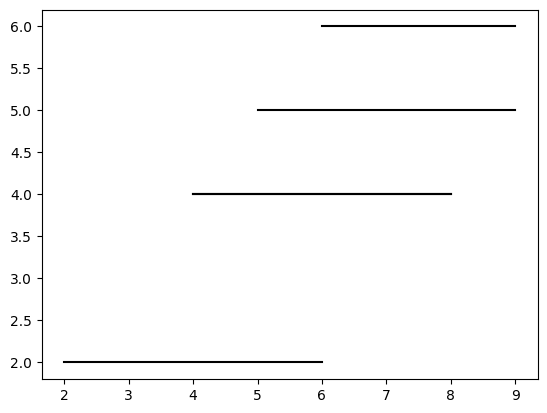

In [3]:
utils.plot_line(epitopes, y="start", c="black")
plt.show()

## Stretching
If we want to focus, not on individual epitopes, but all epitopes at a position,
we can use the `stretch()` function. This function "stretches" the epitopes so we have
a record for each position the epitope overlaps. This is useful because we can then group
epitopes by their overlapping positions.

Stretch epitopes so each position they occupy is recorded.
This means that instead of each row being an epitope,
each row is a position occupied by a given epitope.
Effectively duplicate each row for each residue in its epitope
and adding a column indicating the position of that residue.


In [4]:
stretched_epitopes = stretch.stretch(epitopes)
stretched_epitopes.head()

,start,end,seq,length,position,residue
0,2,6,NLPV,4,2,N
0,2,6,NLPV,4,3,L
0,2,6,NLPV,4,4,P
0,2,6,NLPV,4,5,V
2,4,8,PVGT,4,4,P


This allows us to assess all the epitopes at a given position
Use groupby on the new position column and then apply whatever function you like.

For example, `size` counts the number of epitopes overlapping a given position. There is another example later in this notebook, or look up pandas `groupby` for more detail on these type of functions.

In [5]:
positional_count = stretched_epitopes.groupby("position").size()
positional_count


position
2    1
3    1
4    3
5    4
6    4
7    4
8    2
dtype: int64

Note that there are not records for positions without any epitopes
But we can add them with `add_empty_positions()`.


In [6]:
positional_count = stretch.add_empty_positions(
    positional_count,
    seq_length=len(sequence),
    index=1,
    empty_value=0
)

Now we have the number of epitopes overlapping each position in the parent sequence.
We can easily plot this to see which regions are epitope rich.

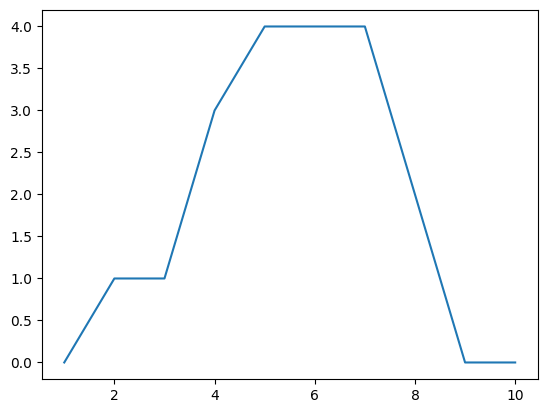

In [7]:
plt.plot(positional_count)
plt.show()


## Epitope grids
We can group epitopes by position and someother variable, eg MHC allele, to get an epitope grid.

Create some random epitopes and create a new column for fictional MHC alleles that recognise these epitopes.

In [8]:
sequence = utils.random_seq(10)
epitopes = utils.random_epitopes(sequence, n=5, epitope_lengths=(3,6), index=0, includeend=False)
epitopes['mhc_allele'] = ["x","x","y","z","z"]

print(sequence)
epitopes

WFRCNCYFDP


,start,end,seq,length,mhc_allele
0,6,9,YFD,3,x
1,5,9,CYFD,4,x
2,3,6,CNC,3,y
3,0,3,WFR,3,z
4,3,6,CNC,3,z


Now we stretch the epitopes, same as before.

In [9]:
stretched_epitopes = stretch.stretch(epitopes)


This is just an example of some more interesting groupby functions we can apply.

In [10]:

stretched_epitopes.groupby("position").agg(
    # Average start position of epitopes overlapping this position
    mean_start=('start', "mean"),
    # number of unique mhc alleles with epitopes at this position
    n_alleles = ('mhc_allele', lambda x: len(set(x)))
)

,mean_start,n_alleles
position,,
0,0.000000,1
1,0.000000,1
2,0.000000,1
3,3.000000,2
4,3.000000,2
5,3.666667,3
6,5.500000,1
7,5.500000,1
8,5.500000,1


Lets use groupby to count the number of epitopes for each MHC allele, at each position.

In [11]:
allele_position_count = stretched_epitopes.groupby(["mhc_allele", "position"]).size()
allele_position_count

mhc_allele  position
x           5           1
            6           2
            7           2
            8           2
y           3           1
            4           1
            5           1
z           0           1
            1           1
            2           1
            3           1
            4           1
            5           1
dtype: int64

The above result doesn't have values for all position-allele combinations. We can add them using `add_empty_positions()`.
Or we can use `make_grid()` which automatically fills in missing values.

In [13]:
grid = stretch.make_grid(
    allele_position_count,
    index=0,
    seq_length=len(sequence),
    empty_value=0
)

grid

0                           
position    0  1  2  3  4  5  6  7  8  9
mhc_allele                              
x           0  0  0  0  0  1  2  2  2  0
y           0  0  0  1  1  1  0  0  0  0
z           1  1  1  1  1  1  0  0  0  0

We can plot this matrix easily using `matplotlib` which is very useful for viewing this
type of grids for lots of MHC alleles.

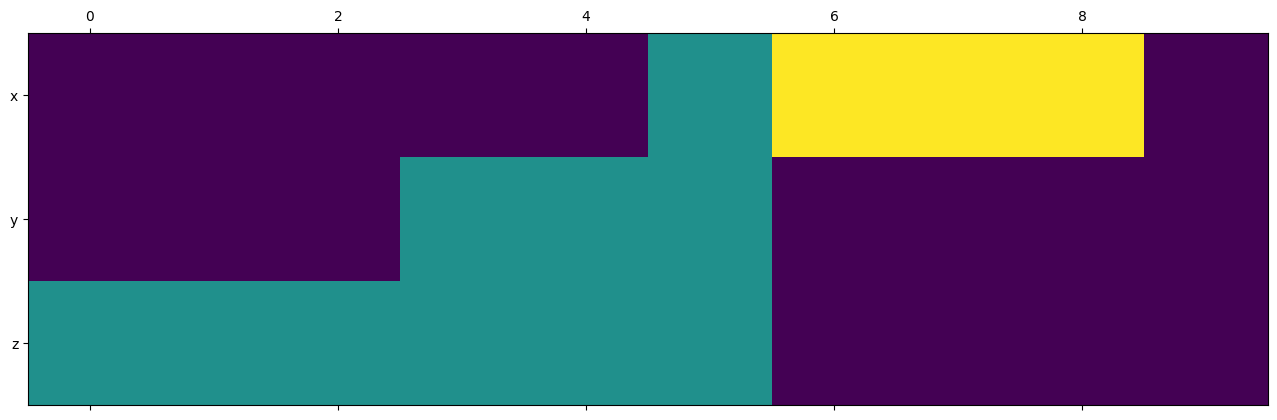

In [16]:
plt.matshow(grid)
plt.yticks(np.arange(len(grid.index)), labels=grid.index)
plt.show()